In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/Root/Root"

In [ ]:
classes = os.listdir(dataset_path)
print("Classes:", classes)

Classes: ['spinach', 'cabbage', 'mustard greens', 'lettuce', 'radish leaves', 'red amaranth']


Show images from all class


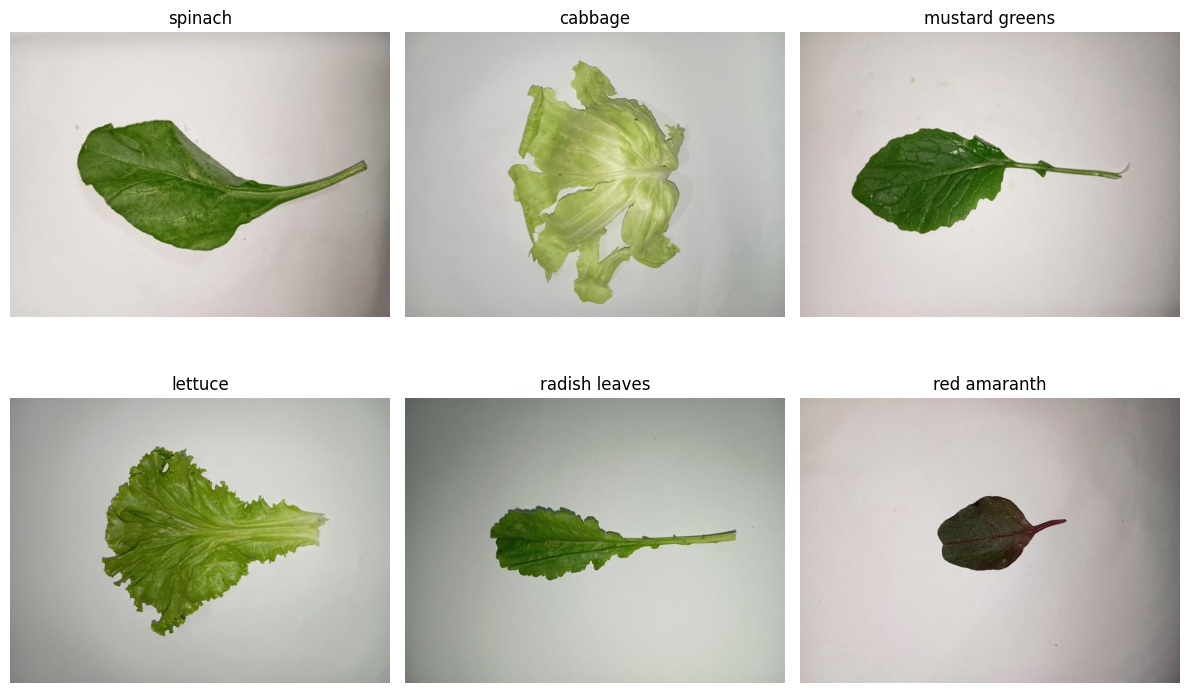

In [ ]:
import matplotlib.pyplot as plt
import random
import os
print("Show images from all class")
plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes[:6]):
    folder = os.path.join(dataset_path, cls)
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    img = plt.imread(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.tight_layout()
plt.show()

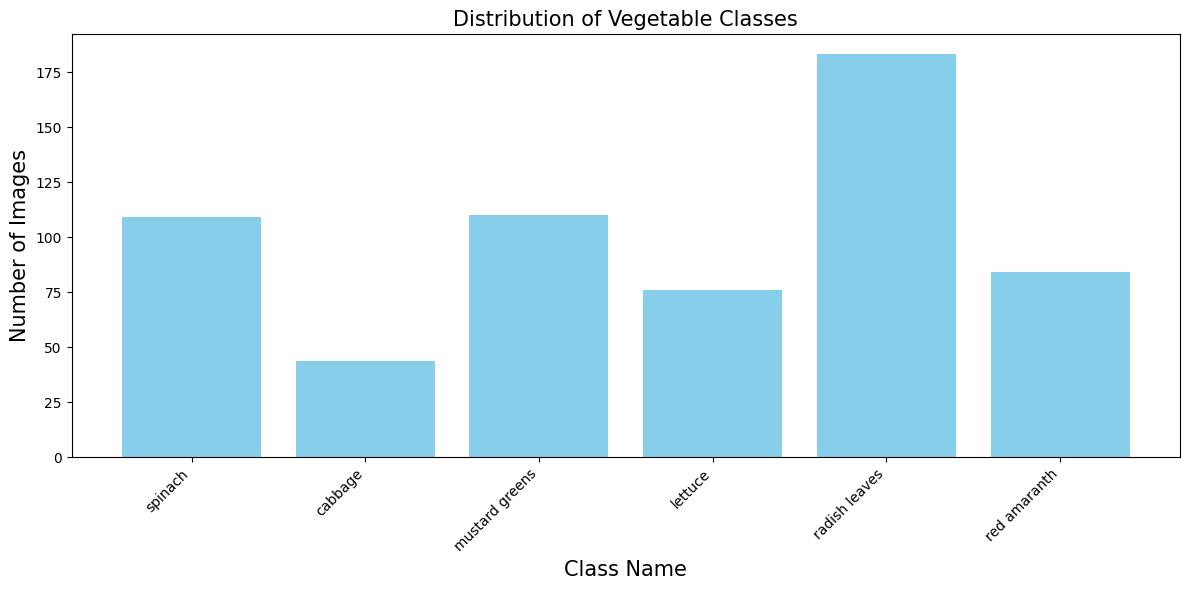

In [ ]:
import matplotlib.pyplot as plt
import os

class_counts = {}
for cls in classes:
    folder_path = os.path.join(dataset_path, cls)
    if os.path.isdir(folder_path):
        class_counts[cls] = len(os.listdir(folder_path))

class_names = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(class_names, counts, color='skyblue')
plt.title('Distribution of Vegetable Classes', size=15)
plt.xlabel('Class Name', size=15)
plt.ylabel('Number of Images', size=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_height = 75
image_width = 75
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_ds = datagen.flow_from_directory(
    dataset_path,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

test_ds = datagen.flow_from_directory(
    dataset_path,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 488 images belonging to 6 classes.
Found 118 images belonging to 6 classes.


In [ ]:
def plot_history(history, model_name):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


def evaluate_model(model, dataset, model_name):
    all_x = []
    all_y_true = []
    test_ds.reset()

    for _ in range(len(test_ds)):
        x, y = next(test_ds)
        all_x.append(x)
        all_y_true.append(y)

    X_test = np.concatenate(all_x, axis=0)
    Y_test = np.concatenate(all_y_true, axis=0)

    y_true = np.argmax(Y_test, axis=1);

    y_pred_probs = model.predict(X_test);
    y_pred = np.argmax(y_pred_probs, axis=1);

    cm = confusion_matrix(y_true, y_pred);

    plt.figure(figsize=(8,8));
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues');
    plt.xlabel('Predicted');
    plt.ylabel('Actual');
    plt.title('ResNet50 Confusion Matrix');
    plt.show();

    print("\nClassification Report for ResNet50:");
    print(classification_report(y_true, y_pred, target_names=class_names));

In [ ]:
def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
def build_transfer_model(base_model, num_classes):
    base_model.trainable = True
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalMaxPooling2D(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
num_classes = 6
input_shape = (image_height, image_width, 3) # Changed from (64,64,3) to match image_height and image_width
epochs = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

results = {}

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 617ms/step - accuracy: 0.3540 - loss: 4.3598 - val_accuracy: 0.1864 - val_loss: 1.8101
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.6772 - loss: 1.6066 - val_accuracy: 0.2119 - val_loss: 2.4275
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.7236 - loss: 1.0021 - val_accuracy: 0.0932 - val_loss: 4.8718
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.7777 - loss: 0.8870 - val_accuracy: 0.0678 - val_loss: 7.4208
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.8228 - loss: 0.7467 - val_accuracy: 0.0678 - val_loss: 9.6692
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.8848 - loss: 0.3710 - val_accuracy: 0.0678 - val_loss: 11.0845
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.8415 - loss: 0.4962 - val_accuracy: 0.0678 - val_loss: 13.2112
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.8995 - loss: 0.2949 - val_accuracy:

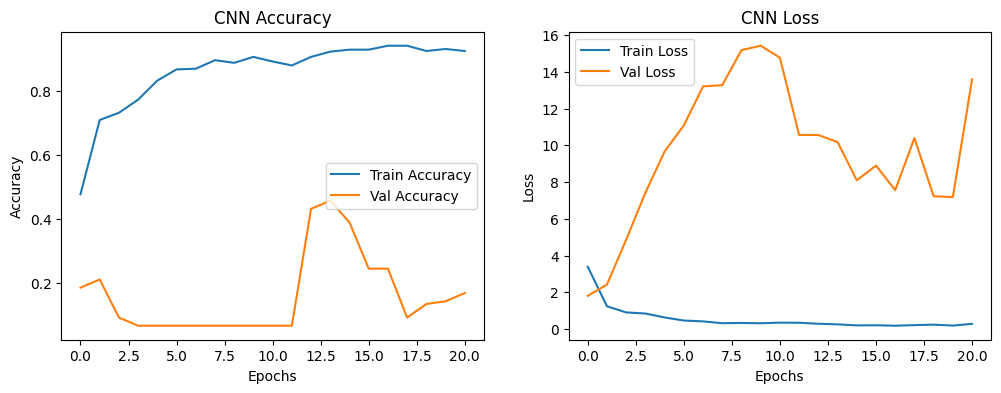

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


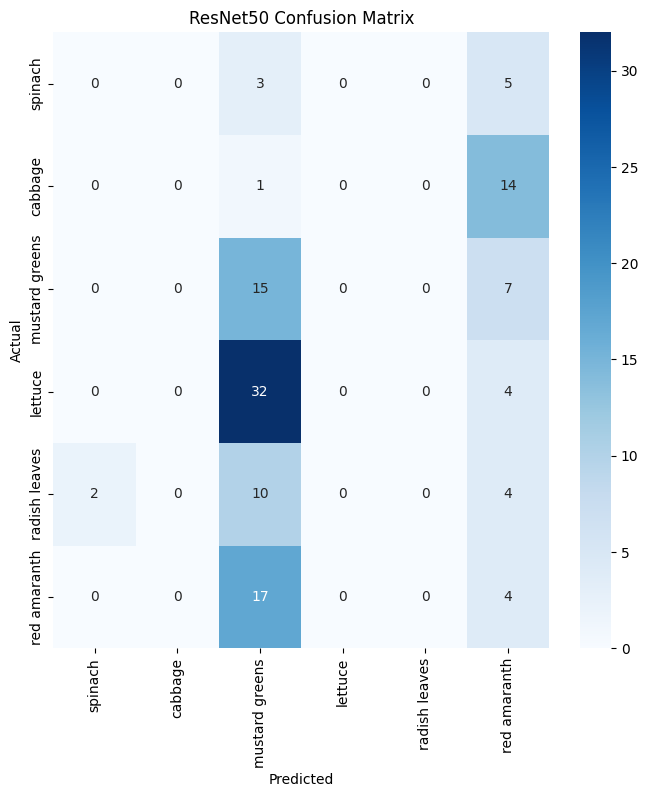


Classification Report for ResNet50:
                precision    recall  f1-score   support

       spinach       0.00      0.00      0.00         8
       cabbage       0.00      0.00      0.00        15
mustard greens       0.19      0.68      0.30        22
       lettuce       0.00      0.00      0.00        36
 radish leaves       0.00      0.00      0.00        16
  red amaranth       0.11      0.19      0.14        21

      accuracy                           0.16       118
     macro avg       0.05      0.15      0.07       118
  weighted avg       0.05      0.16      0.08       118



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
cnn_model = build_cnn(input_shape, num_classes)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

plot_history(history, "CNN")

evaluate_model(cnn_model, test_ds, "CNN")

results["CNN"] = history.history

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2372 - loss: 2.5681 - val_accuracy: 0.4661 - val_loss: 1.5285
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.3095 - loss: 1.6755 - val_accuracy: 0.4915 - val_loss: 1.4222
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.4367 - loss: 1.4103 - val_accuracy: 0.4322 - val_loss: 1.4280
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.4273 - loss: 1.3991 - val_accuracy: 0.3898 - val_loss: 1.3711
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.4592 - loss: 1.3379 - val_accuracy: 0.4746 - val_loss: 1.3212
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - accuracy: 0.4798 - loss: 1.3049 - val_accuracy: 0.4322 - val_loss: 1.3497
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.5432 - loss: 1.2337 - val_accuracy: 0.4153 - val_loss: 1.2889
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.4357 - loss: 1.3032 - val_accuracy: 0.46

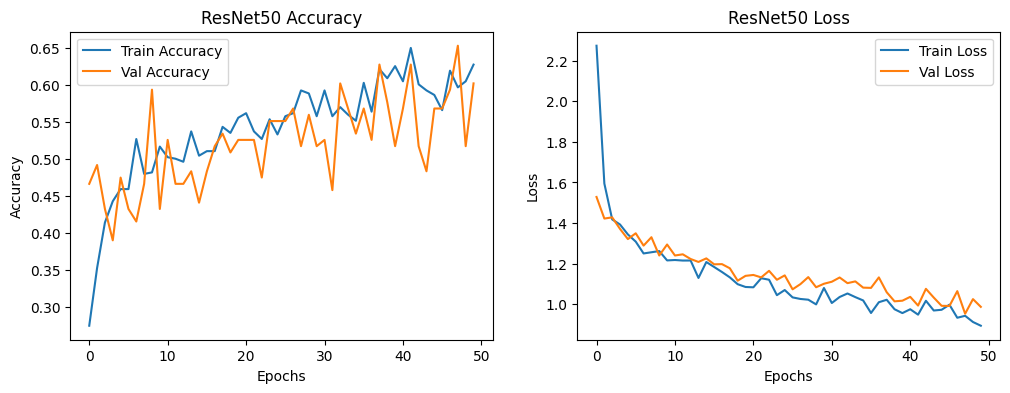

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


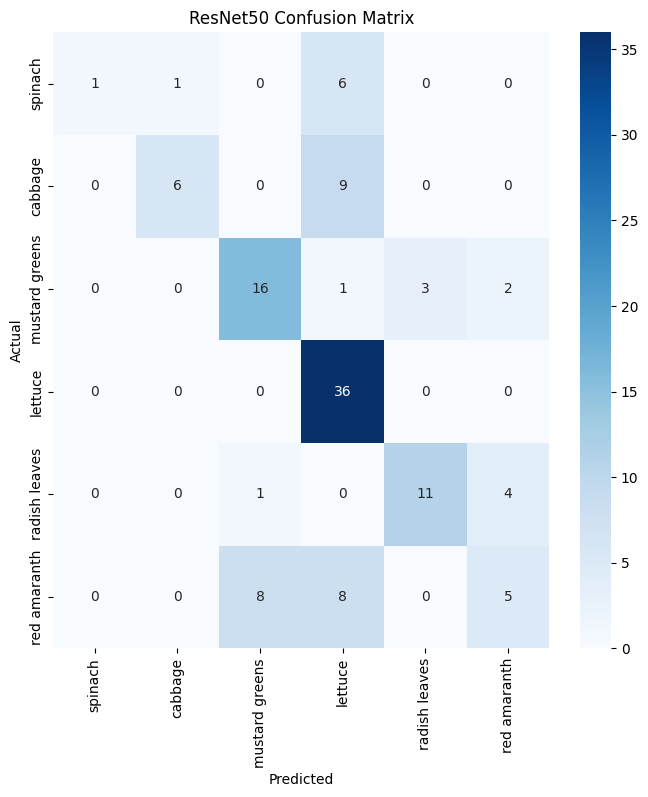


Classification Report for ResNet50:
                precision    recall  f1-score   support

       spinach       1.00      0.12      0.22         8
       cabbage       0.86      0.40      0.55        15
mustard greens       0.64      0.73      0.68        22
       lettuce       0.60      1.00      0.75        36
 radish leaves       0.79      0.69      0.73        16
  red amaranth       0.45      0.24      0.31        21

      accuracy                           0.64       118
     macro avg       0.72      0.53      0.54       118
  weighted avg       0.67      0.64      0.60       118



In [ ]:
from tensorflow.keras.applications import ResNet50

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_base.trainable = False

resnet_model = models.Sequential([
    resnet_base,
    layers.GlobalMaxPooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = resnet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

plot_history(history, "ResNet50")

evaluate_model(resnet_model, test_ds, "ResNet50")

results["ResNet50"] = history.history

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3373 - loss: 1.8383 - val_accuracy: 0.7034 - val_loss: 1.0388
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.6817 - loss: 0.9007 - val_accuracy: 0.7881 - val_loss: 0.7214
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 489ms/step - accuracy: 0.8147 - loss: 0.5890 - val_accuracy: 0.8051 - val_loss: 0.9567
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accuracy: 0.8312 - loss: 0.5914 - val_accuracy: 0.8051 - val_loss: 0.6826
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.8162 - loss: 0.5173 - val_accuracy: 0.8390 - val_loss: 0.5179
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.7988 - loss: 0.4967 - val_accuracy: 0.8390 - val_loss: 0.7079
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.8636 - loss: 0.4141 - val_accuracy: 0.8305 - val_loss: 0.6067
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - a

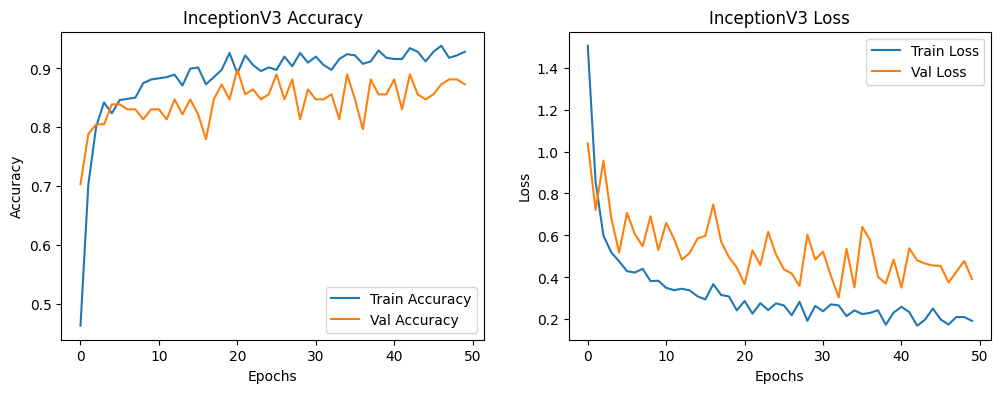

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


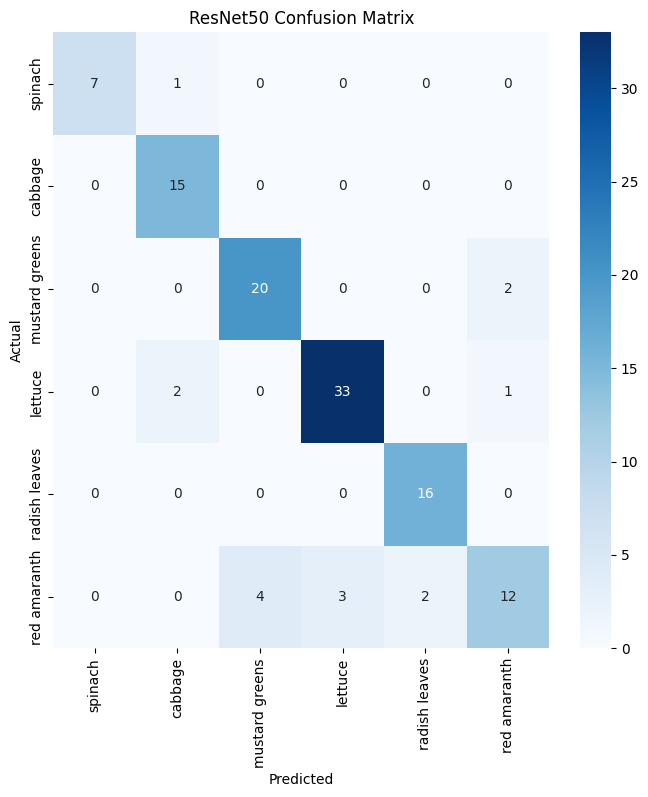


Classification Report for ResNet50:
                precision    recall  f1-score   support

       spinach       1.00      0.88      0.93         8
       cabbage       0.83      1.00      0.91        15
mustard greens       0.83      0.91      0.87        22
       lettuce       0.92      0.92      0.92        36
 radish leaves       0.89      1.00      0.94        16
  red amaranth       0.80      0.57      0.67        21

      accuracy                           0.87       118
     macro avg       0.88      0.88      0.87       118
  weighted avg       0.87      0.87      0.87       118



In [ ]:
from tensorflow.keras.applications import InceptionV3

inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
inception_base.trainable = False

inception_model = models.Sequential([
    inception_base,
    layers.GlobalMaxPooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

inception_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = inception_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

plot_history(history, "InceptionV3")

evaluate_model(inception_model, test_ds, "InceptionV3")

results["InceptionV3"] = history.history

In [ ]:
inception_model.save('/content/drive/MyDrive/Colab Notebooks/Vegetable_best_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


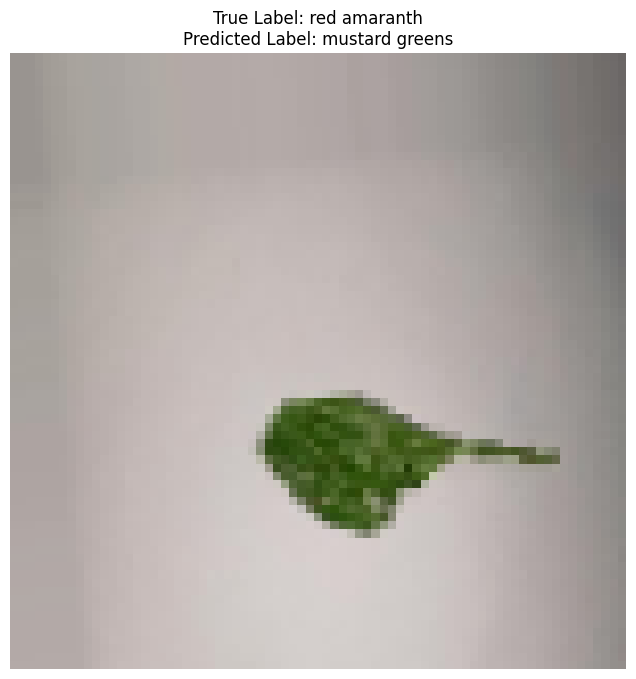

Confidence Scores (Probabilities):
  spinach: 0.1390
  cabbage: 0.1381
  mustard greens: 0.2790
  lettuce: 0.1282
  radish leaves: 0.0840
  red amaranth: 0.2317


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

img_batch, label_batch = next(iter(test_ds))

sample_image = img_batch[0]
true_label_one_hot = label_batch[0]

true_label_idx = np.argmax(true_label_one_hot)
true_class_name = class_names[true_label_idx]

input_image_for_prediction = np.expand_dims(sample_image, axis=0)

predictions = cnn_model.predict(input_image_for_prediction)
predicted_probabilities = predictions[0]
predicted_label_idx = np.argmax(predicted_probabilities)
predicted_class_name = class_names[predicted_label_idx]

plt.figure(figsize=(8, 8))
plt.imshow(sample_image)
plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}")
plt.axis('off')
plt.show()

print("Confidence Scores (Probabilities):")
for i, prob in enumerate(predicted_probabilities):
    print(f"  {class_names[i]}: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


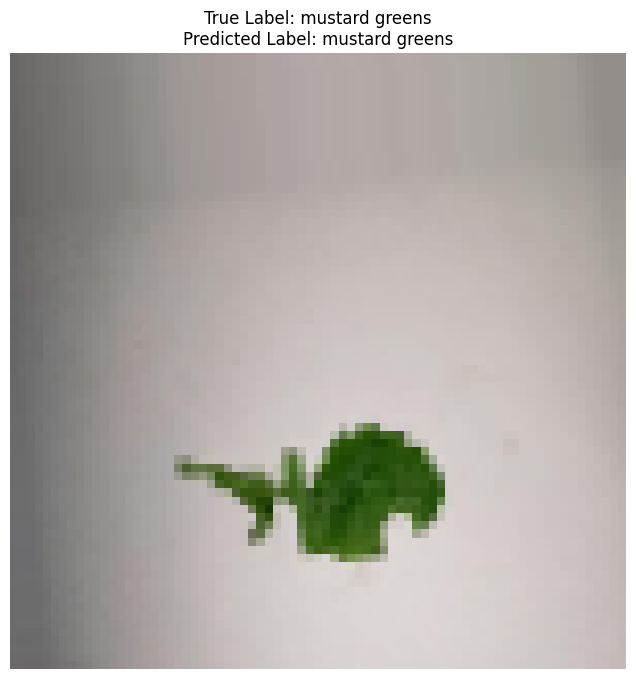

Confidence Scores (Probabilities):
  spinach: 0.0081
  cabbage: 0.0499
  mustard greens: 0.3809
  lettuce: 0.3255
  radish leaves: 0.0523
  red amaranth: 0.1832


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

img_batch, label_batch = next(iter(test_ds))

sample_image = img_batch[0]
true_label_one_hot = label_batch[0]

true_label_idx = np.argmax(true_label_one_hot)
true_class_name = class_names[true_label_idx]

input_image_for_prediction = np.expand_dims(sample_image, axis=0)

predictions = resnet_model.predict(input_image_for_prediction)
predicted_probabilities = predictions[0]
predicted_label_idx = np.argmax(predicted_probabilities)
predicted_class_name = class_names[predicted_label_idx]

plt.figure(figsize=(8, 8))
plt.imshow(sample_image)
plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}")
plt.axis('off')
plt.show()

print("Confidence Scores (Probabilities):")
for i, prob in enumerate(predicted_probabilities):
    print(f"  {class_names[i]}: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


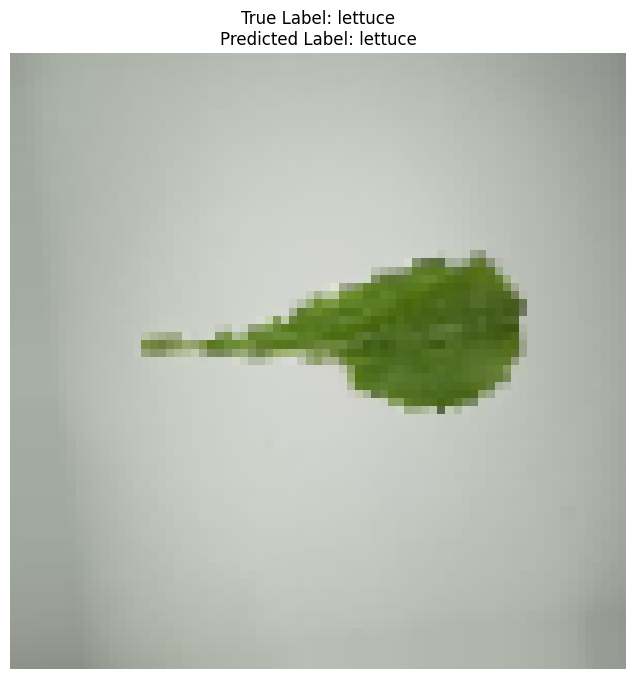

Confidence Scores (Probabilities):
  spinach: 0.0003
  cabbage: 0.0071
  mustard greens: 0.0047
  lettuce: 0.8419
  radish leaves: 0.0001
  red amaranth: 0.1458


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

img_batch, label_batch = next(iter(test_ds))

sample_image = img_batch[0]
true_label_one_hot = label_batch[0]

true_label_idx = np.argmax(true_label_one_hot)
true_class_name = class_names[true_label_idx]

input_image_for_prediction = np.expand_dims(sample_image, axis=0)

predictions = inception_model.predict(input_image_for_prediction)
predicted_probabilities = predictions[0]
predicted_label_idx = np.argmax(predicted_probabilities)
predicted_class_name = class_names[predicted_label_idx]

plt.figure(figsize=(8, 8))
plt.imshow(sample_image)
plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}")
plt.axis('off')
plt.show()

print("Confidence Scores (Probabilities):")
for i, prob in enumerate(predicted_probabilities):
    print(f"  {class_names[i]}: {prob:.4f}")